In [1]:
import os
import numpy as np
from keras.datasets.mnist import load_data
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import Flatten
from keras.layers import Reshape
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model
from numpy import expand_dims
from numpy import ones
from numpy import zeros
from numpy.random import randn
from numpy.random import rand
from numpy import vstack
from numpy.random import randint
from matplotlib import pyplot

In [2]:
#Exploring ways to better organise data
DATA_FOLDER = "../data/real_faces/"
print(f"Real Faces for Training: {len(os.listdir(os.path.join(DATA_FOLDER)))}")

Real Faces for Training: 9780


In [3]:
#Defining the standalone descriminator model

#The model must take a sample image from our dataset as input and output a classification prediction as to whether the sample
#is real or fake.

#The discriminator model has two convolutional layers with 64 filters each, a small kernel size of 3, 
# and larger than normal stride of 2. The model has no pooling layers and a single node in the output layer 
# with the sigmoid activation function to predict whether the input sample is real or fake.
#  The model is trained to minimize the binary cross entropy loss function, appropriate for binary classification.

#We will use some of the best practices when it comes to defining a discriminator model such as using LeakyReLU, using dropout,
# and using the Adam version of the gradient descent with a learning rate of 0.0002 and a momentum of 0.5

def define_discriminator(input_shape = (28,28,1)):
    model = Sequential()
    model.add(Conv2D(64, (3,3), strides = (2,2), padding = "same", input_shape = input_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    
	# compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

    return model

Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0         
                                        

2022-03-29 16:45:26.254684: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-29 16:45:26.254819: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/leo/miniforge3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


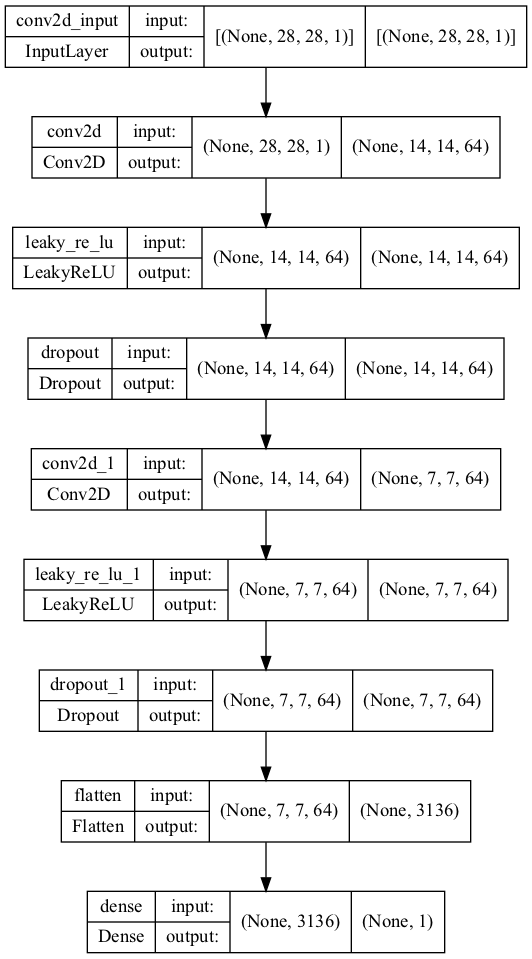

In [4]:
#calling the function to define the model
model = define_discriminator()

#summarizing the model
model.summary()

#plotting the model
plot_model(model, to_file = "discriminator_plot.png", show_shapes = True, show_layer_names = True)

In [5]:
#We need a way to convert our training set into the correct format

def load_real_samples(image_path):

    
    #Defining master array
    master_list = list()

    for image in os.listdir(image_path):
        #loading image
        img = load_img(os.path.join(image_path,image), grayscale=True)
        # convert to numpy array
        img_array = img_to_array(img)

        img_array = tf.image.resize(img_array, [28, 28])
        #Standardizing to float
        #img_array = img_array.astype("float32")
        #Getting value between 0 and 1
        img_array/=255.0

        master_list.append(img_array)

    return np.array(master_list)

In [6]:
training_data = load_real_samples("/Users/leo/Desktop/nova/deep_learning/deepfakedetector/data/real_faces")

/Users/leo/miniforge3/lib/python3.8/site-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [7]:
training_data.shape

(9780, 28, 28, 1)

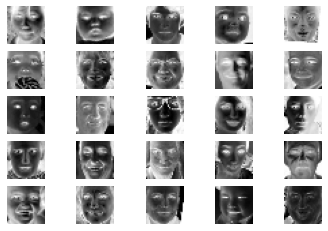

In [8]:
# plot images from the training dataset
for i in range(25):
	# define subplot
	plt.subplot(5, 5, 1 + i)
	# turn off axis
	plt.axis('off')
	# plot raw pixel data
	plt.imshow(training_data[i], cmap='gray_r')
plt.show()

In [9]:
#When we are training the model we need to provide it with both real and generated characters
#So we need to define a function to provide it with a random subset of real images

def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y

In [10]:
generate_real_samples(dataset=load_real_samples("/Users/leo/Desktop/nova/deep_learning/deepfakedetector/data/real_faces"), n_samples = 4000)

(array([[[[0.38431376],
          [0.40756306],
          [0.3806723 ],
          ...,
          [0.85630256],
          [0.7793317 ],
          [0.67871153]],
 
         [[0.36128455],
          [0.3943978 ],
          [0.3907563 ],
          ...,
          [0.82857156],
          [0.73893553],
          [0.65966386]],
 
         [[0.3526611 ],
          [0.36132455],
          [0.37394962],
          ...,
          [0.7812926 ],
          [0.7358543 ],
          [0.6918768 ]],
 
         ...,
 
         [[0.2767507 ],
          [0.2708484 ],
          [0.27563024],
          ...,
          [0.6879553 ],
          [0.57841134],
          [0.5334335 ]],
 
         [[0.2661065 ],
          [0.24947983],
          [0.25434172],
          ...,
          [0.6795519 ],
          [0.547899  ],
          [0.48683473]],
 
         [[0.3484795 ],
          [0.2854942 ],
          [0.2392157 ],
          ...,
          [0.65564233],
          [0.5415165 ],
          [0.49773914]]],
 
 
        [

In [11]:
# generate n fake samples with class labels as for the time being we don't have a generator model
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

In [12]:
#We will ignore the idea of epochs for now (e.g. complete passes through the training dataset) and 
# fit the discriminator model for a fixed number of batches. The model will learn to discriminate between 
# real and fake (randomly generated) images rapidly, therefore, not many batches will be required before it learns 
# to discriminate perfectly.

#The train_discriminator() function implements this, using a batch size of 256 images where 128 are real 
# and 128 are fake each iteration.

#We update the discriminator separately for real and fake examples so that we can calculate the accuracy of the 
# model on each sample prior to the update. This gives insight into how the discriminator model is performing over time.

# train the discriminator model
def train_discriminator(model, dataset, n_iter=100, n_batch=256):
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_iter):
		# get randomly selected 'real' samples
		X_real, y_real = generate_real_samples(dataset, half_batch)
		# update discriminator on real samples
		_, real_acc = model.train_on_batch(X_real, y_real)
		# generate 'fake' examples
		X_fake, y_fake = generate_fake_samples(half_batch)
		# update discriminator on fake samples
		_, fake_acc = model.train_on_batch(X_fake, y_fake)
		# summarize performance
		print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

### Creating a GAN Model that Trains Itself

In [14]:
#The general idea of the model

#THe weights in the generator are updated based off the performance of the discriminator model
#When the discriminator is good at detecting fakes, the generators weights are updated to a larger extent, when the discriminator is not so good, in an attempt to not fix something that
#isn't broken, the generator updates its weights a lot less

#Creating a global model that contains the generator and the discriminator, using the Keras API

def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [15]:
# define the standalone generator model that takes in as an input the dimension of the latent space that we are going to use to assign meaning to certain patterns found in the training process
def define_generator(latent_dim):
	model = Sequential()

	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))

	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
	return model

In [16]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 28, 28, 1)         1164289   
                                                                 
 sequential_2 (Sequential)   (None, 1)                 40705     
                                                                 
Total params: 1,204,994
Trainable params: 1,164,289
Non-trainable params: 40,705
_________________________________________________________________


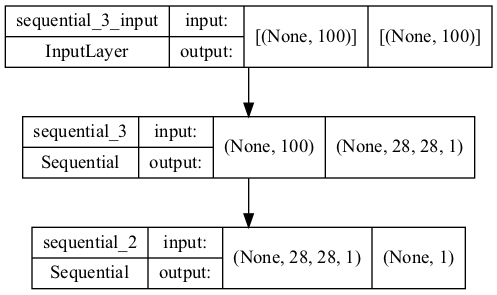

In [17]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# summarize gan model
gan_model.summary()
# plot gan model
plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

In [20]:
#When we are training the model we need to first feed the discriminator model the real and fake data and then update the generator 

# evaluate the discriminator, plot generated images, save generator model

# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()
	
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch + 1)
	g_model.save(filename)

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# create training set for the discriminator
			X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
			# update discriminator model weights
			d_loss, _ = d_model.train_on_batch(X, y)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [21]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples("/Users/leo/Desktop/nova/deep_learning/deepfakedetector/data/real_faces")
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

2022-03-29 16:50:18.449659: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-29 16:50:18.617851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-29 16:50:18.886920: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


>1, 1/38, d=0.700, g=0.620
>1, 2/38, d=0.699, g=0.631
>1, 3/38, d=0.694, g=0.638
>1, 4/38, d=0.694, g=0.645
>1, 5/38, d=0.691, g=0.654
>1, 6/38, d=0.687, g=0.661
>1, 7/38, d=0.686, g=0.665
>1, 8/38, d=0.684, g=0.671
>1, 9/38, d=0.681, g=0.677
>1, 10/38, d=0.680, g=0.685
>1, 11/38, d=0.676, g=0.696
>1, 12/38, d=0.672, g=0.705
>1, 13/38, d=0.669, g=0.715
>1, 14/38, d=0.665, g=0.720
>1, 15/38, d=0.663, g=0.724
>1, 16/38, d=0.659, g=0.723
>1, 17/38, d=0.655, g=0.723
>1, 18/38, d=0.654, g=0.723
>1, 19/38, d=0.652, g=0.719
>1, 20/38, d=0.649, g=0.714
>1, 21/38, d=0.646, g=0.709
>1, 22/38, d=0.643, g=0.713
>1, 23/38, d=0.636, g=0.716
>1, 24/38, d=0.636, g=0.713
>1, 25/38, d=0.633, g=0.708
>1, 26/38, d=0.628, g=0.701
>1, 27/38, d=0.624, g=0.696
>1, 28/38, d=0.616, g=0.693
>1, 29/38, d=0.613, g=0.706
>1, 30/38, d=0.604, g=0.736
>1, 31/38, d=0.600, g=0.771
>1, 32/38, d=0.594, g=0.779
>1, 33/38, d=0.598, g=0.758
>1, 34/38, d=0.598, g=0.722
>1, 35/38, d=0.602, g=0.689
>1, 36/38, d=0.597, g=0.679
>

2022-03-29 16:51:13.172037: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-29 16:51:13.279173: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


>Accuracy real: 36%, fake: 0%
>11, 1/38, d=0.019, g=0.667
>11, 2/38, d=0.027, g=0.652
>11, 3/38, d=0.026, g=0.597
>11, 4/38, d=0.023, g=0.626
>11, 5/38, d=0.021, g=0.627
>11, 6/38, d=0.019, g=0.642
>11, 7/38, d=0.024, g=0.638
>11, 8/38, d=0.022, g=0.625
>11, 9/38, d=0.023, g=0.618
>11, 10/38, d=0.025, g=0.583
>11, 11/38, d=0.021, g=0.596
>11, 12/38, d=0.018, g=0.652
>11, 13/38, d=0.020, g=0.658
>11, 14/38, d=0.020, g=0.632
>11, 15/38, d=0.018, g=0.607
>11, 16/38, d=0.017, g=0.635
>11, 17/38, d=0.019, g=0.622
>11, 18/38, d=0.018, g=0.639
>11, 19/38, d=0.017, g=0.636
>11, 20/38, d=0.015, g=0.645
>11, 21/38, d=0.018, g=0.644
>11, 22/38, d=0.017, g=0.653
>11, 23/38, d=0.017, g=0.617
>11, 24/38, d=0.019, g=0.582
>11, 25/38, d=0.018, g=0.594
>11, 26/38, d=0.017, g=0.600
>11, 27/38, d=0.018, g=0.642
>11, 28/38, d=0.019, g=0.621
>11, 29/38, d=0.016, g=0.608
>11, 30/38, d=0.014, g=0.638
>11, 31/38, d=0.018, g=0.624
>11, 32/38, d=0.015, g=0.640
>11, 33/38, d=0.013, g=0.639
>11, 34/38, d=0.013, g